<a href="https://colab.research.google.com/github/marcosw1998/Data-Science/blob/main-igor/Analysis_Notebook/covid_spends_brazil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise dos custos do governo de Pernambuco - BR em relação à Covid-19**
* Projeto corresponde a entrega parcial para avaliação na cadeira eletiva IF697 - Intro. a Ciência dos Dados
* Autores: Igor Silva e Marcos Cavalcanti
* Conjunto de dados públicos retirados das seguintes fontes:
  * [Portal da Transparência TCU](http://www.portaltransparencia.gov.br/coronavirus)
  * [Prefeitura do Recife](http://dados.recife.pe.gov.br/dataset?tags=sa%C3%BAde)
  * [Brasil.io](https://brasil.io/dataset/covid19/caso_full/)



## **Por quê o tema?**

* Interesse em entender e expor de forma clara os gastos públicos
* Analisar distribuição de gastos
* Covis-19 é um tema importante e merece muita atenção, pois tem feito muitas vítimas e mudado a forma como a sociedade pensa e se organiza
* Entender a distribuição de gastos é uma boa forma de tentar corrigir erros e minimizar danos futuros na economia e na sociedade

## **Carregando as bibliotecas**

  * Utilizaremos a biblioteca ***`Pandas`*** para trabalhar sobre os dados  e a biblioteca ***`Numpy`*** para operações sobre os datasets.
  



In [2]:
import numpy as np
import pandas as pd

Instalação do Pyspark

In [3]:
!pip install pyspark

     |████████████████████████████████| 212.3MB 66kB/s 
     |████████████████████████████████| 204kB 20.5MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=1e834535d5415e86968c248e572f6b127e93be3dd96d9101ce8f2231041af873
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [4]:
import pyspark
from pyspark import SparkContext
sc = SparkContext("local", "first app")

## **Carregando os dados**

  * Utilizaremos a lib ***`requests`*** para carregar os dados em formato csv e em seguida convertê-los em JSON
  * Referência: https://www.nylas.com/blog/use-python-requests-module-rest-apis/ 
  * Instalação, caso o python não tenha instalado nativamente:
     ```
      !pip install requests
      ```



In [71]:
# !pip install requests

### Portal da transparência

* O portal da transparência permite que sejam baixados apenas 1000 registros por vez, portanto decidimos por baixar 2 datasets diferentes e depois fazermos a junção. Os dados são referentes a algumas cidades de Pernambuco 
(Recife, Jaboatão, Olinda, Paulista, Caruaru, Garanhuns, Petrolina, Arcoverde, Serra Talhada, Buíque)

In [72]:
invest_covidPe = pd.read_csv("https://raw.githubusercontent.com/marcosw1998/Data-Science/main-mwac/Datasets/covid-pe.csv",encoding = "utf-8")
invest_covidPe2 = pd.read_csv("https://raw.githubusercontent.com/marcosw1998/Data-Science/main-mwac/Datasets/transferencias_coronavirus.csv",encoding = "utf-8")

In [73]:
#Validando os dados do dataset invest_covidPe
print('Dataset 1',invest_covidPe.shape)
invest_covidPe.sort_values("Município").head()

Dataset 1 (561, 12)


,Mês/Ano,Tipo,Tipo de Favorecido,UF,Nome do Favorecido,CPF/CNPJ,Município,Função,Programa Orçamentário,Ação Orçamentária,Linguagem Cidadã,Valor Transferido
182,nov/20,Legais. Voluntárias e Específicas,Fundo Público,PE,FUNDO MUNICIPAL DE SAUDE,11.371.082/0001-05,CARUARU,Saúde,ATENCAO ESPECIALIZADA A SAUDE,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,Sem informação,486.515.00
178,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,ASSOCICAO DE PAIS E MESTRES,11.252.224/0001-07,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,PDDE,7.897.02
179,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,CONSELHO ESCOLAR MARIA DO SOCORRO DE FREITAS,02.021.769/0001-11,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,PDDE,2.837.48
87,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,CONSELHO ESCOLAR DOM BERNARDINO MARCHIO,34.179.420/0001-07,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,PDDE,8.427.56
181,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,UNIDADE EXECUTORA MAJOR DR.SINVAL,11.441.171/0001-72,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,PDDE,2.274.59


In [74]:
#Validando os dados do dataset invest_covidPe2
print('Dataset 2',invest_covidPe2.shape)
invest_covidPe2.sort_values("Município").head()

Dataset 2 (140, 10)


,Mês/Ano,Tipo,Ação Orçamentária,Programa Orçamentário,Função,Tipo de Favorecido,UF,Município,Valor Transferido,Unnamed: 9
98,12/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,ATENCAO ESPECIALIZADA A SAUDE,10 - Saúde,Fundo Público,PE,ARCOVERDE,R$ 134.639.00,NaN
41,05/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,PROTECAO SOCIAL NO AMBITO DO SISTEMA UNICO DE ...,08 - Assistência social,Fundo Público,PE,ARCOVERDE,R$ 470.809.62,NaN
42,11/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,ATENCAO ESPECIALIZADA A SAUDE,10 - Saúde,Fundo Público,PE,ARCOVERDE,R$ 355.594.00,NaN
32,04/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,ATENCAO ESPECIALIZADA A SAUDE,10 - Saúde,Fundo Público,PE,ARCOVERDE,R$ 761.895.71,NaN
56,08/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,PROTECAO SOCIAL NO AMBITO DO SISTEMA UNICO DE ...,08 - Assistência social,Fundo Público,PE,ARCOVERDE,R$ 218.971.54,NaN


*Podemos perceber que o Dataset **invest_covidPe** possui mais colunas que o Dataset **invest_covidPe2**.  Também notamos que o Dataset invest_covidPe2 possui uma coluna com dados Nan, vamos tratar disso no pré processamento antes de fazer a concatenação dos dois Datasets*

### Dados abertos - Prefeitura do Recife

In [75]:
import requests

dados_pref_rmr = requests.get("http://dados.recife.pe.gov.br/dataset/6c77a814-7161-4eb5-9662-234642dc8cc1/resource/63376b8c-0271-42eb-a88b-cc75c1c3f3fc/download/metadados-hospitais.json").json()

### Dados de casos de Covid-19 por todo o estado de Pernambuco. 
Os valores estão atualizados até o dia 17/03/2021 e foram buscados através do Brasil.io

In [76]:
covidPeCases = pd.read_csv("https://raw.githubusercontent.com/marcosw1998/Data-Science/main-mwac/Datasets/covid19-1703-casos.csv",encoding = "utf-8")
print(covidPeCases.shape)
covidPeCases.sort_values("city").head()

(187, 16)


,epidemiological_week,date,order_for_place,state,city,city_ibge_code,place_type,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,new_confirmed,last_available_deaths,new_deaths,last_available_death_rate,estimated_population,is_last,is_repeated
1,202111,2021-03-15,341,PE,Abreu e Lima,2600054.0,city,1700,1694.13828,8,159,1,0.0935,100346.0,True,False
2,202111,2021-03-15,321,PE,Afogados da Ingazeira,2600104.0,city,2478,6624.95990,1,35,0,0.0141,37404.0,True,False
3,202111,2021-03-15,321,PE,Afrânio,2600203.0,city,578,2917.71832,0,9,0,0.0156,19810.0,True,False
4,202111,2021-03-15,326,PE,Agrestina,2600302.0,city,865,3451.02733,2,36,0,0.0416,25065.0,True,False
7,202111,2021-03-15,331,PE,Alagoinha,2600609.0,city,443,3009.91983,0,13,0,0.0293,14718.0,True,False


## **Pré Processamento**
  * Junção de datasets em Dataframe Pandas
  * Tratamento de dados ```NaN```/```null``` ou corrompidos
  * Conversão de tipos
  * Transformação e identificação de dados categóricos
  * Remoção de ***Outliers*** Multivariado

### **Tratamento dos dados de Gastos Públicos**

In [77]:
# Verificando se existem registros duplicados
print("Número de registros duplicados")
print("Dataset 1",len(invest_covidPe[invest_covidPe.duplicated()]))
print("Dataset 2",len(invest_covidPe2[invest_covidPe2.duplicated()]))


Número de registros duplicados
Dataset 1 0
Dataset 2 0


In [78]:
#Checando se temos valores Nan
print('Dataset 1',invest_covidPe.isnull().sum())
print('Dataset 1',invest_covidPe2.isnull().sum())

Dataset 1 Mês/Ano                  0
Tipo                     0
Tipo de Favorecido       0
UF                       0
Nome do Favorecido       0
CPF/CNPJ                 0
Município                0
Função                   0
Programa Orçamentário    0
Ação Orçamentária        0
Linguagem Cidadã         0
Valor Transferido        0
dtype: int64
Dataset 1 Mês/Ano                    0
Tipo                       0
Ação Orçamentária          0
Programa Orçamentário      0
Função                     0
Tipo de Favorecido         0
UF                         0
Município                  0
Valor Transferido          0
Unnamed: 9               140
dtype: int64


> Remoção colunas que não fazem parte do dataset invest_covidPe2 e que não influem sobre os nossos estudos (Nome do favorecido, CPF/CNPJ, Linguagem Cidadã)

>```invest_covidPe = invest_covidPe.dropna(axis=1, how='all')```

In [79]:
cols = [4,5,10]
invest_covidPe.drop(invest_covidPe.columns[cols],axis=1,inplace=True)
invest_covidPe.sort_values("Município").head()

,Mês/Ano,Tipo,Tipo de Favorecido,UF,Município,Função,Programa Orçamentário,Ação Orçamentária,Valor Transferido
182,nov/20,Legais. Voluntárias e Específicas,Fundo Público,PE,CARUARU,Saúde,ATENCAO ESPECIALIZADA A SAUDE,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,486.515.00
178,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,7.897.02
179,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,2.837.48
87,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,8.427.56
181,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,2.274.59


> Remoção coluna que tem todos os valores Nan

In [80]:
invest_covidPe2.dropna(axis=1, how='all',inplace=True)
invest_covidPe2.sort_values("Município").head()

,Mês/Ano,Tipo,Ação Orçamentária,Programa Orçamentário,Função,Tipo de Favorecido,UF,Município,Valor Transferido
98,12/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,ATENCAO ESPECIALIZADA A SAUDE,10 - Saúde,Fundo Público,PE,ARCOVERDE,R$ 134.639.00
41,05/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,PROTECAO SOCIAL NO AMBITO DO SISTEMA UNICO DE ...,08 - Assistência social,Fundo Público,PE,ARCOVERDE,R$ 470.809.62
42,11/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,ATENCAO ESPECIALIZADA A SAUDE,10 - Saúde,Fundo Público,PE,ARCOVERDE,R$ 355.594.00
32,04/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,ATENCAO ESPECIALIZADA A SAUDE,10 - Saúde,Fundo Público,PE,ARCOVERDE,R$ 761.895.71
56,08/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,PROTECAO SOCIAL NO AMBITO DO SISTEMA UNICO DE ...,08 - Assistência social,Fundo Público,PE,ARCOVERDE,R$ 218.971.54


> Retirando prefixo numérico e caracteres especiais dos valores da categoria 'Função'

In [81]:
invest_covidPe_funcao = invest_covidPe2['Função'].map(lambda words: str(words[5:]))
invest_covidPe2['Função'].update(invest_covidPe_funcao)
invest_covidPe2['Função'].unique()

array(['Educação', 'Saúde', 'Assistência social', 'Ciência e Tecnologia'],
      dtype=object)

> Confirmando que as colunas foram removidas e agora os 2 datasets possuem a mesma quantidade de colunas

In [82]:
print('Dataset 1',invest_covidPe.shape)
print('Dataset 2',invest_covidPe2.shape)

Dataset 1 (561, 9)
Dataset 2 (140, 9)


> Fazendo a concatenação dos Dataframes, o resultado final de linhas é igual ao somatório de linhas entre ambos os Datasets

In [83]:
invest_covidPe = invest_covidPe.append(invest_covidPe2, ignore_index=True)

> Filtragem de gastos com a saúde e retirada das colunas **Tipo**, **UF**, **Programa Orçamentário** e **Função** por não conterem dados variados.

In [84]:
# Filtragem

invest_covidPe = invest_covidPe[invest_covidPe['Função'] == 'Saúde']

# Drop colunas

invest_covidPe.drop({'Tipo',\
                     'UF',\
                     'Programa Orçamentário', \
                     'Função'},\
                    axis=1,\
                    inplace=True \
                    )
invest_covidPe

,Mês/Ano,Tipo de Favorecido,Município,Ação Orçamentária,Valor Transferido
0,mar/20,Fundo Público,RECIFE,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,60.000.00
1,abr/20,Fundo Público,GARANHUNS,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,1.174.944.27
2,abr/20,Fundo Público,PETROLINA,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,4.130.446.89
3,abr/20,Fundo Público,OLINDA,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,3.830.136.03
4,abr/20,Fundo Público,CARUARU,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,3.662.675.00
...,...,...,...,...,...
695,07/2020,Fundo Público,GARANHUNS,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,R$ 4.995.000.00
696,04/2020,Fundo Público,JABOATÃO DOS GUARARAPES,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,R$ 7.327.021.87
697,10/2020,Fundo Público,RECIFE,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,R$ 3.500.000.00
698,07/2020,Fundo Público,PETROLINA,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,R$ 8.676.053.00


Renomeando colunas

In [85]:
invest_covidPe = invest_covidPe.rename(columns={'Mês/Ano': 'data_hora', \
                                                'Município': 'municipio', \
                                                'Tipo de Favorecido': 'tipo_favorecido', \
                                                'Ação Orçamentária': 'acao_orcamentaria', \
                                                'Valor Transferido': 'gastos' \
                                                })
invest_covidPe.head(3)

,data_hora,tipo_favorecido,municipio,acao_orcamentaria,gastos
0,mar/20,Fundo Público,RECIFE,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,60.000.00
1,abr/20,Fundo Público,GARANHUNS,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,1.174.944.27
2,abr/20,Fundo Público,PETROLINA,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,4.130.446.89


#### **Conversão de tipos das colunas**

  * Valor Transferido (rename -> gastos): ```string``` -> ```float```

  * Mês/Ano (rename -> data_hora): ```string``` -> ```pandas.Datetime```

  * Dados categóricos: ```object``` -> ```category```

In [86]:
invest_covidPe.dtypes

data_hora            object
tipo_favorecido      object
municipio            object
acao_orcamentaria    object
gastos               object
dtype: object

##### **Valor Transferido**
```object``` -> ```float64```

In [87]:
# Tratamento e conversão do CSV-String para float
invest_covidPe['valores_transferidos'] = invest_covidPe['gastos'].apply(lambda words: words.replace('R$ ', ''))
valores_transferidos = invest_covidPe['valores_transferidos'].map(lambda words: float(words[:-3].replace('.','') + words[-3:]))
valores_transferidos = valores_transferidos.astype('float64')
#valores_transferidos = valores_transferidos.astype(float)

In [88]:
invest_covidPe.head(3)

,data_hora,tipo_favorecido,municipio,acao_orcamentaria,gastos,valores_transferidos
0,mar/20,Fundo Público,RECIFE,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,60.000.00,60.000.00
1,abr/20,Fundo Público,GARANHUNS,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,1.174.944.27,1.174.944.27
2,abr/20,Fundo Público,PETROLINA,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,4.130.446.89,4.130.446.89


In [89]:
# Atualiza o dataset principal
invest_covidPe['gastos'].update(valores_transferidos)
invest_covidPe.drop('valores_transferidos',axis=1,inplace=True)
invest_covidPe = invest_covidPe.infer_objects()
invest_covidPe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 699
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   data_hora          149 non-null    object 
 1   tipo_favorecido    149 non-null    object 
 2   municipio          149 non-null    object 
 3   acao_orcamentaria  149 non-null    object 
 4   gastos             149 non-null    float64
dtypes: float64(1), object(4)
memory usage: 7.0+ KB


##### **Data (timestamp)**
```object``` -> ```pandas.Datetime```

Obs.: Apenas necessário para o caso de análise de séries temporais.

In [90]:
# Transformando os dados da coluna data_hora em pandas.Datetime
invest_covidPe['data_hora'] = invest_covidPe['data_hora'].astype('string')
invest_covidPe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 699
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   data_hora          149 non-null    string 
 1   tipo_favorecido    149 non-null    object 
 2   municipio          149 non-null    object 
 3   acao_orcamentaria  149 non-null    object 
 4   gastos             149 non-null    float64
dtypes: float64(1), object(3), string(1)
memory usage: 7.0+ KB


In [91]:
meses = {'mar/20' : '2020-03-10', \
         'abr/20' : '2020-04-10', \
         'mai/20' : '2020-05-10', \
         'jun/20' : '2020-06-10', \
         'jul/20' : '2020-07-10', \
         'ago/20' : '2020-08-10', \
         'set/20' : '2020-09-10', \
         'out/20' : '2020-10-10', \
         'nov/20' : '2020-11-10', \
         'dez/20' : '2020-12-10', \
         '03/2020' : '2020-03-10', \
         '04/2020' : '2020-04-10', \
         '05/2020' : '2020-05-10', \
         '06/2020' : '2020-06-10', \
         '07/2020' : '2020-07-10', \
         '08/2020' : '2020-08-10', \
         '09/2020' : '2020-09-10', \
         '10/2020' : '2020-10-10', \
         '11/2020' : '2020-11-10', \
         '12/2020' : '2020-12-10'
         }

invest_covidPe['data_hora'] = invest_covidPe['data_hora'].apply(lambda dates: dates.replace(dates, meses[dates]))

invest_covidPe['data_hora'].unique()

array(['2020-03-10', '2020-04-10', '2020-05-10', '2020-06-10',
       '2020-07-10', '2020-08-10', '2020-09-10', '2020-10-10',
       '2020-11-10', '2020-12-10'], dtype=object)

In [92]:
# convert the 'Date' column to datetime format
invest_covidPe['data_hora'] = pd.to_datetime(invest_covidPe['data_hora'])

# Check the format of 'Date' column
invest_covidPe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 699
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   data_hora          149 non-null    datetime64[ns]
 1   tipo_favorecido    149 non-null    object        
 2   municipio          149 non-null    object        
 3   acao_orcamentaria  149 non-null    object        
 4   gastos             149 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 7.0+ KB


##### **Definindo dados categóricos**

Conversão de dados categóricos
> ```object``` -> ```category```

In [93]:
invest_covidPe['municipio'] = invest_covidPe['municipio'].astype('category')
invest_covidPe['tipo_favorecido'] = invest_covidPe['tipo_favorecido'].astype('category')
invest_covidPe['acao_orcamentaria'] = invest_covidPe['acao_orcamentaria'].astype('category')
invest_covidPe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 699
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   data_hora          149 non-null    datetime64[ns]
 1   tipo_favorecido    149 non-null    category      
 2   municipio          149 non-null    category      
 3   acao_orcamentaria  149 non-null    category      
 4   gastos             149 non-null    float64       
dtypes: category(3), datetime64[ns](1), float64(1)
memory usage: 4.5 KB


### **Tratamento dos dados de casos de covid-19 em PE**

Filtragem de categorias

In [94]:
covidPeCases = covidPeCases.filter(items=['city', \
                                         'last_available_confirmed', \
                                         'last_available_deaths', \
                                         'last_available_death_rate', \
                                         'estimated_population' \
                                         ])
covidPeCases

,city,last_available_confirmed,last_available_deaths,last_available_death_rate,estimated_population
0,NaN,323176,11510,0.0356,9616621.0
1,Abreu e Lima,1700,159,0.0935,100346.0
2,Afogados da Ingazeira,2478,35,0.0141,37404.0
3,Afrânio,578,9,0.0156,19810.0
4,Agrestina,865,36,0.0416,25065.0
...,...,...,...,...,...
182,Vertente do Lério,156,2,0.0128,7571.0
183,Vertentes,408,5,0.0123,20954.0
184,Vicência,431,16,0.0371,32772.0
185,Vitória de Santo Antão,3038,186,0.0612,139583.0


Renomeação de colunas

In [95]:
covidPeCases = covidPeCases.rename(columns={"city": "municipio", \
                                           "last_available_confirmed": "casos_confirmados", \
                                           "last_available_deaths": "mortes_confirmadas", \
                                           "last_available_death_rate": "taxa_mortalidade", \
                                           "estimated_population": "pop_estimada" \
                                           })
covidPeCases

,municipio,casos_confirmados,mortes_confirmadas,taxa_mortalidade,pop_estimada
0,NaN,323176,11510,0.0356,9616621.0
1,Abreu e Lima,1700,159,0.0935,100346.0
2,Afogados da Ingazeira,2478,35,0.0141,37404.0
3,Afrânio,578,9,0.0156,19810.0
4,Agrestina,865,36,0.0416,25065.0
...,...,...,...,...,...
182,Vertente do Lério,156,2,0.0128,7571.0
183,Vertentes,408,5,0.0123,20954.0
184,Vicência,431,16,0.0371,32772.0
185,Vitória de Santo Antão,3038,186,0.0612,139583.0


Filtrar cidades do dataset de Gastos públicos

In [96]:
#Guardando uma cópia dos dados de todas as cidades
oldCovidPeCases = covidPeCases

#Filtrando as cidades que selecionamos os gastos no portal da transparência
cities = ['Arcoverde', \
          'Buíque', \
          'Caruaru', \
          'Garanhuns', \
          'Jaboatão dos Guararapes', \
          'Olinda', \
          'Paulista', \
          'Petrolina', \
          'Recife', \
          'Serra Talhada']

covidPeCases = covidPeCases[covidPeCases.municipio.isin(cities)]
covidPeCases

,municipio,casos_confirmados,mortes_confirmadas,taxa_mortalidade,pop_estimada
14,Arcoverde,4281,87,0.0203,74822.0
30,Buíque,1436,23,0.0160,58919.0
45,Caruaru,17187,454,0.0264,365278.0
67,Garanhuns,7250,134,0.0185,140577.0
89,Jaboatão dos Guararapes,19966,1095,0.0548,706867.0
113,Olinda,14581,635,0.0435,393115.0
124,Paulista,7154,528,0.0738,334376.0
128,Petrolina,18239,209,0.0115,354317.0
134,Recife,78117,3168,0.0406,1653461.0
160,Serra Talhada,7341,105,0.0143,86915.0


In [97]:
covidPeCases.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 14 to 160
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   municipio           10 non-null     object 
 1   casos_confirmados   10 non-null     int64  
 2   mortes_confirmadas  10 non-null     int64  
 3   taxa_mortalidade    10 non-null     float64
 4   pop_estimada        10 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 480.0+ bytes


In [100]:
covidPeCases['municipio'].apply(lambda city: city.upper())
covidPeCases['municipio'].unique()

array(['ARCOVERDE', 'BUÍQUE', 'CARUARU', 'GARANHUNS',
       'JABOATÃO DOS GUARARAPES', 'OLINDA', 'PAULISTA', 'PETROLINA',
       'RECIFE', 'SERRA TALHADA'], dtype=object)

In [124]:
covidPeCases['municipio'] = covidPeCases['municipio'].astype('category')
covidPeCases['id'] = covidPeCases['municipio'].cat.codes
covidPeCases.index = covidPeCases['id']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [123]:
covidPeCases

,municipio,casos_confirmados,mortes_confirmadas,taxa_mortalidade,pop_estimada
id,,,,,
0,ARCOVERDE,4281,87,0.0203,74822.0
1,BUÍQUE,1436,23,0.0160,58919.0
2,CARUARU,17187,454,0.0264,365278.0
3,GARANHUNS,7250,134,0.0185,140577.0
4,JABOATÃO DOS GUARARAPES,19966,1095,0.0548,706867.0
5,OLINDA,14581,635,0.0435,393115.0
6,PAULISTA,7154,528,0.0738,334376.0
7,PETROLINA,18239,209,0.0115,354317.0
8,RECIFE,78117,3168,0.0406,1653461.0


### **Remoção de outliers multivariado**
> Método utilizado:
  * Local Outlier Factor

> Conjunto:
  * ```investCovidPE```

Categorizando Gastos públicos

Método para vincular os dados de municípios entre os dois Conjuntos de Dados

In [ ]:
def categorizar_municipio(city):
  return covidPeCases[covidPeCases['municipio'] == str(city)].index.values.astype(int)[0]

In [125]:
invest_covidPe['municipio'] = invest_covidPe['municipio'].map(lambda city: city.replace(city, str(categorizar_municipio(city))))
invest_covidPe['tipo_favorecido'] = invest_covidPe['tipo_favorecido'].cat.codes
invest_covidPe['acao_orcamentaria'] = invest_covidPe['acao_orcamentaria'].cat.codes

In [127]:
invest_covidPe

,data_hora,tipo_favorecido,municipio,acao_orcamentaria,gastos
0,2020-03-10,1,8,1,60000.00
1,2020-04-10,1,3,1,1174944.27
2,2020-04-10,1,7,1,4130446.89
3,2020-04-10,1,5,1,3830136.03
4,2020-04-10,1,2,1,3662675.00
...,...,...,...,...,...
695,2020-07-10,1,3,0,4995000.00
696,2020-04-10,1,4,0,7327021.87
697,2020-10-10,1,8,0,3500000.00
698,2020-07-10,1,7,0,8676053.00


Para avaliação do melhor resultado para remoção de outliers, serão utilizados 
cópias dos dataframes gerados

In [126]:
invest_covidPe_lof = invest_covidPe
print("Quantidade de linhas: " + str(len(invest_covidPe)))

Quantidade de linhas: 149


#### **Local Outlier Factor**

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=10)

In [ ]:
scores = clf.fit_predict(invest_covidPe_lof)

In [ ]:
# Valor de LOF
-1*clf.negative_outlier_factor_

array([ 5.06972406,  1.15786907,  1.01278478,  1.00743069,  0.97511367,
        1.38735342,  1.14246381,  0.9815729 ,  0.9388996 ,  1.06181494,
        1.03345647,  1.00099309,  1.46929686,  0.96742529,  1.19792081,
        1.05815846,  1.32094043,  1.11359083,  0.88391166,  1.28701849,
        1.0212535 ,  1.05815846,  1.0811027 ,  1.03028305,  0.96950344,
        1.09989847,  1.71633666,  1.09000524,  1.17392687,  1.32513546,
        1.24460724,  1.24460724,  0.98706486,  0.95898566,  0.9073941 ,
        1.17776213,  1.30074647,  0.94080509,  1.1715444 ,  1.04785782,
        0.98969908,  1.22973992,  0.93931047,  1.10569106,  1.11086792,
        1.0155732 ,  0.95207123,  1.0404531 ,  1.40262619,  1.03760092,
        0.98506441,  1.31220308,  0.94483734,  1.00836771,  1.03237359,
        1.37091875,  1.17742638,  0.99612669,  1.02220098,  0.93716132,
        0.99639615,  1.03726531,  1.04823382,  1.4031783 ,  1.0998123 ,
        1.15410589,  1.13631687,  1.024645  ,  1.08351131,  0.97

In [ ]:
scores

array([-1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [ ]:
invest_covidPe_lof['outlier'] = scores
print(invest_covidPe_lof.head())

   data_hora  Tipo  favorecido  ...  acao_orcamentaria      gastos  outlier
0          0     0           2  ...                  3    60000.00       -1
1          1     0           2  ...                  3  1174944.27        1
2          1     0           2  ...                  3  4130446.89        1
3          1     0           2  ...                  3  3830136.03        1
4          1     0           2  ...                  3  3662675.00        1

[5 rows x 10 columns]


In [ ]:
invest_covidPe_lof[invest_covidPe_lof['outlier'] == -1]

,data_hora,Tipo,favorecido,UF,municipio,funcao,prog_ocamentario,acao_orcamentaria,gastos,outlier
0,0,0,2,0,8,7,0,3,60000.00,-1
26,3,0,2,0,8,4,2,3,2264395.80,-1
96,8,0,1,0,8,6,1,2,-534.86,-1
149,8,0,1,0,8,6,1,2,-1084.16,-1
212,8,0,1,0,7,6,1,2,12037.82,-1
241,8,0,1,0,8,6,1,2,-1248.01,-1
243,8,0,1,0,8,6,1,2,-2529.72,-1
259,8,0,1,0,2,6,1,2,1342.91,-1
562,8,0,1,0,8,2,1,0,-1619.02,-1
589,8,0,1,0,8,2,1,0,-3777.73,-1


In [ ]:
invest_covidPe_lof = invest_covidPe_lof[invest_covidPe_lof['outlier'] != -1]
len(invest_covidPe_lof)

688

## **Análise dos casos**

 > ***Insights***:
 * Distribuição de casos de Covid-19 em Pernambuco
 * Junção dos datasets de casos de covid-19 
 com gastos públicos na saúde em Pernabuco
 * Discretização dos gastos

### **Discretização dos gastos por habitante** 
> *Nível de gastos* :
1. Muito baixo
2. Baixo
3. Médio
4. Alto 
5. Muito alto

In [ ]:
print('intervalos', pd.cut(covidPeCases['gastos_por_habitante'].values,5).categories)
covidPeCases['nivel_de_gastos'] = pd.cut(covidPeCases['gastos_por_habitante'].values,5).codes + 1
covidPeCases

intervalos IntervalIndex([(38.395, 99.604], (99.604, 160.508], (160.508, 221.412], (221.412, 282.316], (282.316, 343.22]],
              closed='right',
              dtype='interval[float64]')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,municipio,casos_confirmados,mortes_confirmadas,taxa_mortalidade,pop_estimada,confirmados_por_populacao,gastos,gastos_por_habitante,nivel_de_gastos
14,Arcoverde,4281,87,2.03,74822,5.72,7.993327e+06,106.83,2
30,Buíque,1436,23,1.60,58919,2.44,3.872970e+06,65.73,1
45,Caruaru,17187,454,2.64,365278,4.71,5.164707e+07,141.39,2
67,Garanhuns,7250,134,1.85,140577,5.16,3.445661e+07,245.11,4
89,Jaboatão dos Guararapes,19966,1095,5.48,706867,2.82,9.509845e+07,134.54,2
113,Olinda,14581,635,4.35,393115,3.71,4.233129e+07,107.68,2
124,Paulista,7154,528,7.38,334376,2.14,1.294073e+07,38.70,1
128,Petrolina,18239,209,1.15,354317,5.15,1.216093e+08,343.22,5
134,Recife,78117,3168,4.06,1653461,4.72,3.015280e+08,182.36,3
160,Serra Talhada,7341,105,1.43,86915,8.45,1.535898e+07,176.71,3


In [ ]:
covidPeCases.corr(method='spearman')

,casos_confirmados,mortes_confirmadas,taxa_mortalidade,pop_estimada,confirmados_por_populacao,gastos,gastos_por_habitante,nivel_de_gastos
casos_confirmados,1.000000,0.793939,0.187879,0.903030,0.054545,0.975758,0.612121,0.503503
mortes_confirmadas,0.793939,1.000000,0.709091,0.963636,-0.357576,0.757576,0.151515,0.069232
taxa_mortalidade,0.187879,0.709091,1.000000,0.551515,-0.624242,0.115152,-0.515152,-0.547560
pop_estimada,0.903030,0.963636,0.551515,1.000000,-0.236364,0.878788,0.321212,0.213989
confirmados_por_populacao,0.054545,-0.357576,-0.624242,-0.236364,1.000000,0.078788,0.612121,0.736374
gastos,0.975758,0.757576,0.115152,0.878788,0.078788,1.000000,0.696970,0.591616
gastos_por_habitante,0.612121,0.151515,-0.515152,0.321212,0.612121,0.696970,1.000000,0.962950
nivel_de_gastos,0.503503,0.069232,-0.547560,0.213989,0.736374,0.591616,0.962950,1.000000


### **Visualizações e Exploração dos dados**
> **Distribuição de gastos no estado**
  * log10
  * Correlação Pearson-Spearman

> ***Insights***:
  * Quantidade de infectados relacionado com os gastos
  * Gastos por município
  * Gastos por quantidade de infectados no estado (Análise temporal)
  * etc

##### Gastos em saúde

In [ ]:
invest_covidPe['log_gastos'] = invest_covidPe['gastos'].apply(np.log10)
invest_covidPe[invest_covidPe['log_gastos'] > 0]['log_gastos'].hist()

In [ ]:
invest_covidPe[invest_covidPe['log_gastos'] > 0].describe()

,gastos,log_gastos
count,5.900000e+01,59.000000
mean,4.926925e+06,6.271521
std,6.973253e+06,0.709423
min,1.000000e+04,4.000000
25%,6.450940e+05,5.809610
50%,2.135901e+06,6.329581
75%,5.095789e+06,6.707127
max,3.057880e+07,7.485420


##### Zona Geográfica
  * RMR
  * Zona da Mata
  * Agreste

##### Casos confirmados de covid-19

In [ ]:
#Criando um campo que nos permita relacionar a quantidade de casos confirmados pela população estimada
covidPeCases['confirmados_por_populacao'] = covidPeCases['casos_confirmados']/covidPeCases['pop_estimada']
covidPeCases

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,municipio,casos_confirmados,mortes_confirmadas,taxa_mortalidade,pop_estimada,confirmados_por_populacao
14,Arcoverde,4281,87,0.0203,74822.0,0.057216
30,Buíque,1436,23,0.0160,58919.0,0.024372
45,Caruaru,17187,454,0.0264,365278.0,0.047052
67,Garanhuns,7250,134,0.0185,140577.0,0.051573
89,Jaboatão dos Guararapes,19966,1095,0.0548,706867.0,0.028246
113,Olinda,14581,635,0.0435,393115.0,0.037091
124,Paulista,7154,528,0.0738,334376.0,0.021395
128,Petrolina,18239,209,0.0115,354317.0,0.051477
134,Recife,78117,3168,0.0406,1653461.0,0.047245
160,Serra Talhada,7341,105,0.0143,86915.0,0.084462


In [ ]:
covidPeCases.dtypes

Ajustando tipo e transformando valores para porcentagem a fim de facilitar a percepção das taxas

In [ ]:
covidPeCases['pop_estimada'] = covidPeCases['pop_estimada'].astype('int64')
covidPeCases['taxa_mortalidade'] = covidPeCases['taxa_mortalidade'] * 100
covidPeCases['confirmados_por_populacao'] = (covidPeCases['confirmados_por_populacao'] * 100).round(2)
covidPeCases

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,municipio,casos_confirmados,mortes_confirmadas,taxa_mortalidade,pop_estimada,confirmados_por_populacao
14,Arcoverde,4281,87,2.03,74822,5.72
30,Buíque,1436,23,1.60,58919,2.44
45,Caruaru,17187,454,2.64,365278,4.71
67,Garanhuns,7250,134,1.85,140577,5.16
89,Jaboatão dos Guararapes,19966,1095,5.48,706867,2.82
113,Olinda,14581,635,4.35,393115,3.71
124,Paulista,7154,528,7.38,334376,2.14
128,Petrolina,18239,209,1.15,354317,5.15
134,Recife,78117,3168,4.06,1653461,4.72
160,Serra Talhada,7341,105,1.43,86915,8.45


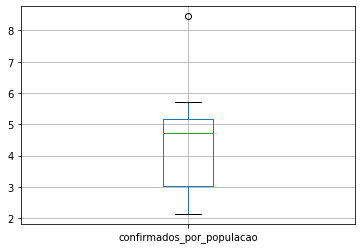

In [ ]:
covidPeCases.boxplot(column=['confirmados_por_populacao'])

In [ ]:
investimentoporcidade = invest_covidPe.groupby(by=['municipio']).sum()
investimentoporcidade

,data_hora,tipo_favorecido,acao_orcamentaria,gastos
municipio,,,,
ARCOVERDE,04/202011/202008/202009/202012/202007/202012/2020,Fundo PúblicoFundo PúblicoFundo PúblicoFundo P...,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,R$ 761.895.71R$ 355.594.00R$ 2.712.707.00R$ 65...
BUÍQUE,04/202008/202012/202009/202011/202007/2020,Fundo PúblicoFundo PúblicoFundo PúblicoFundo P...,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,R$ 82.328.16R$ 522.313.00R$ 17.375.00R$ 553.05...
CARUARU,abr/20mai/20jul/20ago/20set/20nov/20dez/20dez/...,Fundo PúblicoFundo PúblicoFundo PúblicoFundo P...,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,3.662.675.002.000.000.008.589.857.001.940.418....
GARANHUNS,abr/20mai/20jun/20jul/20ago/20set/20nov/20dez/...,Fundo PúblicoFundo PúblicoFundo PúblicoFundo P...,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,1.174.944.27116.254.152.725.586.594.995.000.00...
JABOATÃO DOS GUARARAPES,abr/20mai/20jun/20jul/20ago/20set/20out/20nov/...,Fundo PúblicoFundo PúblicoFundo PúblicoFundo P...,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,7.327.021.871.840.000.004.171.626.9716.162.408...
OLINDA,abr/20mai/20jun/20jul/20ago/20set/20out/20nov/...,Fundo PúblicoFundo PúblicoFundo PúblicoFundo P...,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,3.830.136.03650.000.001.858.864.043.700.000.00...
PAULISTA,12/202006/202012/202007/202004/202008/202005/2...,Fundo PúblicoFundo PúblicoFundo PúblicoFundo P...,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,R$ 952.624.00R$ 208.356.78R$ 291.638.00R$ 4.32...
PETROLINA,abr/20mai/20jun/20jul/20ago/20set/20out/20nov/...,Fundo PúblicoFundo PúblicoFundo PúblicoFundo P...,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,4.130.446.8910.974.866.5410.000.008.676.053.00...
RECIFE,mar/20abr/20mai/20jun/20jul/20ago/20set/20out/...,Fundo PúblicoFundo PúblicoFundo PúblicoFundo P...,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,60.000.0022.986.081.7620.266.709.475.395.807.6...


##### **Junção dos dados de Gastos Públicos e Casos confirmados de Covid-19**

In [ ]:
covidPeCases['gastos'] = investimentoporcidade['gastos'].values
covidPeCases['gastos_por_habitante'] = (covidPeCases['gastos'] / covidPeCases['pop_estimada']).round(2)
covidPeCases

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,municipio,casos_confirmados,mortes_confirmadas,taxa_mortalidade,pop_estimada,confirmados_por_populacao,gastos,gastos_por_habitante
14,Arcoverde,4281,87,2.03,74822,5.72,7.993327e+06,106.83
30,Buíque,1436,23,1.60,58919,2.44,3.872970e+06,65.73
45,Caruaru,17187,454,2.64,365278,4.71,5.164707e+07,141.39
67,Garanhuns,7250,134,1.85,140577,5.16,3.445661e+07,245.11
89,Jaboatão dos Guararapes,19966,1095,5.48,706867,2.82,9.509845e+07,134.54
113,Olinda,14581,635,4.35,393115,3.71,4.233129e+07,107.68
124,Paulista,7154,528,7.38,334376,2.14,1.294073e+07,38.70
128,Petrolina,18239,209,1.15,354317,5.15,1.216093e+08,343.22
134,Recife,78117,3168,4.06,1653461,4.72,3.015280e+08,182.36
160,Serra Talhada,7341,105,1.43,86915,8.45,1.535898e+07,176.71


## Bônus: **Média móvel e Previsão de gastos para 2021**
  * Utilizaremos previsões em Séries Temporais
  * Recursos:
    - Pandas
    - Facebook Prophet

### **Conversão do Dataframe para trabalhar com distribuição temporal**
Conversão necessária para o desenvolvimento dos métodos de séries temporais

In [ ]:
# convert the 'Date' column to datetime format
invest_covidPe['data_hora'] = invest_covidPe['data_hora'].astype('datetime64[ns]')
invest_covidPe.set_index('data_hora')
invest_covidPe.index = pd.to_datetime(invest_covidPe['data_hora'])

# Check the format of 'Date' column
invest_covidPe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59 entries, 2020-03-10 to 2020-12-10
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   data_hora          59 non-null     datetime64[ns]
 1   Tipo               59 non-null     category      
 2   favorecido         59 non-null     category      
 3   UF                 59 non-null     category      
 4   municipio          59 non-null     category      
 5   funcao             59 non-null     category      
 6   prog_ocamentario   59 non-null     category      
 7   acao_orcamentaria  59 non-null     category      
 8   gastos             59 non-null     float64       
 9   log_gastos         59 non-null     float64       
dtypes: category(7), datetime64[ns](1), float64(2)
memory usage: 3.0 KB


In [ ]:
invest_covidPe.drop({'data_hora'},axis=1,inplace=True)
invest_covidPe.head(3)

,Tipo,favorecido,UF,municipio,funcao,prog_ocamentario,acao_orcamentaria,gastos,log_gastos
data_hora,,,,,,,,,
2020-03-10,Legais. Voluntárias e Específicas,Fundo Público,PE,RECIFE,Saúde,ATENCAO ESPECIALIZADA A SAUDE,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,60000.00,4.778151
2020-04-10,Legais. Voluntárias e Específicas,Fundo Público,PE,GARANHUNS,Saúde,ATENCAO ESPECIALIZADA A SAUDE,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,1174944.27,6.070017
2020-04-10,Legais. Voluntárias e Específicas,Fundo Público,PE,PETROLINA,Saúde,ATENCAO ESPECIALIZADA A SAUDE,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,4130446.89,6.615997


### **Visualização dos gastos em todo o estado**

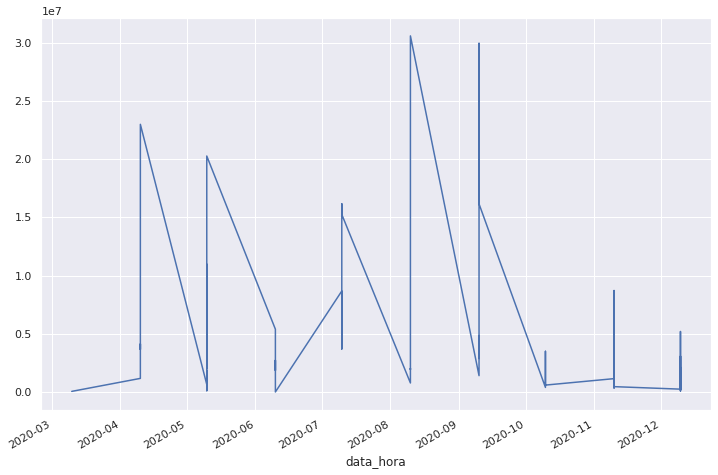

In [ ]:
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import seaborn as sns

%matplotlib inline

plt.figure(figsize=(12, 8))
data = invest_covidPe.gastos
data.plot()

#### **Agregação de dados para visualização**

**Método**:
  * `resample`: *data aggregation*

**Amostragem**:
  * *Semanal* ('5D')
  * *Mensal* ('BM')
  * *Bimestre* ('91D')

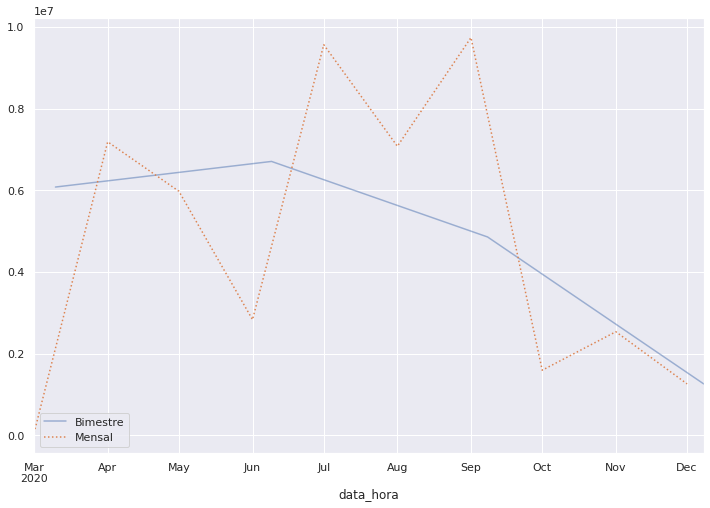

In [ ]:
plt.figure(figsize=(12, 8))
data.resample('91D').mean().plot(alpha=0.5, style='-')
data.resample('BM').mean().plot(style=':')
plt.legend(['Bimestre', 'Mensal'], loc='lower left');

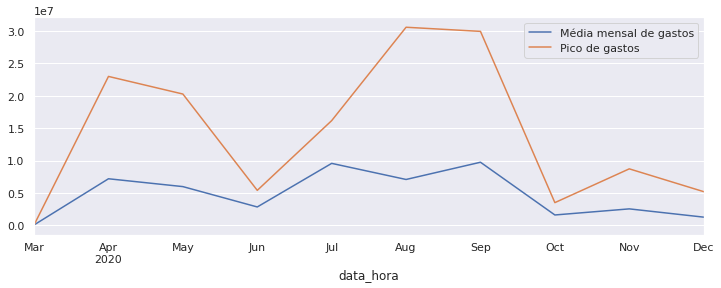

In [ ]:
plt.figure(figsize=(12, 4))
data.resample('BM').mean().plot(label='Média mensal de gastos')
data.resample('BM').max().plot(label='Pico de gastos')
plt.legend()

### Janela deslizante

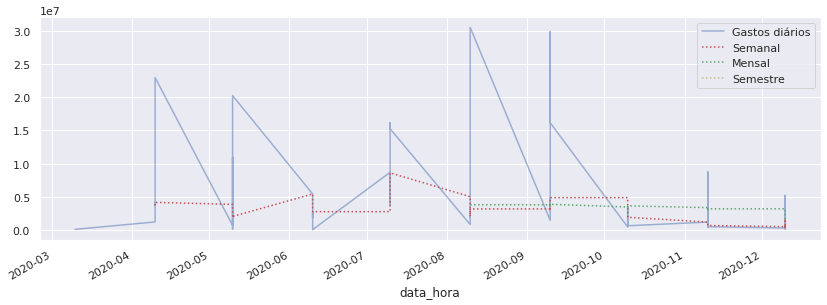

In [ ]:
plt.figure(figsize=(14, 10))

plt.subplot(211)
data.rolling(1).median().plot(label='Gastos diários' , alpha=.5)
(data.rolling(5)
 .median()
 .plot(label="Semanal", style='r:', alpha=1)
)
(data.rolling(30)
 .median()
 .plot(label="Mensal", style='g:', alpha=1)
)
(data.rolling(91)
 .median()
 .plot(label="Semestre", style='y:', alpha=1)
)
plt.legend()

#### Previsões com Prophet

> Realizaremos previsões de gastos semanal, mensal e anual em relação ao estado de pernambuco com o agravamento da covid-19

> O conjunto histórico se dará com o todo o conjunto de dados de Março/2020 até Dezembro/2020

A intenção é avaliar se a previsão corresponde com os meses já passados de 2021 e com os próximos meses até o final do ano.

In [ ]:
!pip install --quiet fbprophet

In [ ]:
invest_covidPe['Tipo'] = invest_covidPe['Tipo'].cat.codes
invest_covidPe['favorecido'] = invest_covidPe['favorecido'].cat.codes
invest_covidPe['UF'] = invest_covidPe['UF'].cat.codes
invest_covidPe['municipio'] = invest_covidPe['municipio'].cat.codes
invest_covidPe['funcao'] = invest_covidPe['funcao'].cat.codes
invest_covidPe['prog_ocamentario'] = invest_covidPe['prog_ocamentario'].cat.codes
invest_covidPe['acao_orcamentaria'] = invest_covidPe['acao_orcamentaria'].cat.codes

Para avaliação do melhor resultado para remoção de outliers, serão utilizados 
cópias dos dataframes gerados

In [ ]:
invest_covidPe_forest = invest_covidPe

In [ ]:
print("Quantidade de linhas: " + str(len(invest_covidPe)))

Quantidade de linhas: 59


#### Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(invest_covidPe_forest)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_iforest.py:281: UserWarning:

max_samples (100) is greater than the total number of samples (59). max_samples will be set to n_samples for estimation.



IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=100, n_estimators=100,
                n_jobs=None,
                random_state=RandomState(MT19937) at 0x7F81AB2EED10, verbose=0,
                warm_start=False)

In [ ]:
scores = clf.predict(invest_covidPe_forest)

In [ ]:
scores

array([-1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1,  1, -1,  1,  1,  1,  1,
       -1,  1, -1,  1,  1, -1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
       -1, -1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1])

In [ ]:
invest_covidPe_forest['outlier'] = scores
print(invest_covidPe_forest.head())

            Tipo  favorecido  UF  ...      gastos  log_gastos  outlier
data_hora                         ...                                 
2020-03-10     0           1   0  ...    60000.00    4.778151       -1
2020-04-10     0           1   0  ...  1174944.27    6.070017        1
2020-04-10     0           1   0  ...  4130446.89    6.615997        1
2020-04-10     0           1   0  ...  3830136.03    6.583214        1
2020-04-10     0           1   0  ...  3662675.00    6.563798        1

[5 rows x 10 columns]


In [ ]:
invest_covidPe_forest[invest_covidPe_forest['outlier'] == -1]

,Tipo,favorecido,UF,municipio,funcao,prog_ocamentario,acao_orcamentaria,gastos,log_gastos,outlier
data_hora,,,,,,,,,,
2020-03-10,0,1,0,5,0,0,0,60000.00,4.778151,-1
2020-04-10,0,1,0,5,0,0,0,22986081.76,7.361465,-1
2020-05-10,0,1,0,1,0,0,0,116254.15,5.065408,-1
2020-05-10,0,1,0,4,0,0,0,10974866.54,7.040399,-1
2020-05-10,0,1,0,5,0,0,0,20266709.47,7.306783,-1
2020-06-10,0,1,0,4,0,0,0,10000.00,4.000000,-1
2020-07-10,0,1,0,0,0,0,0,8589857.00,6.933986,-1
2020-07-10,0,1,0,2,0,0,0,16162408.00,7.208506,-1
2020-07-10,0,1,0,5,0,0,0,15246805.00,7.183179,-1


In [ ]:
invest_covidPe_forest = invest_covidPe_forest[invest_covidPe_forest['outlier'] != -1]
len(invest_covidPe_forest)

45

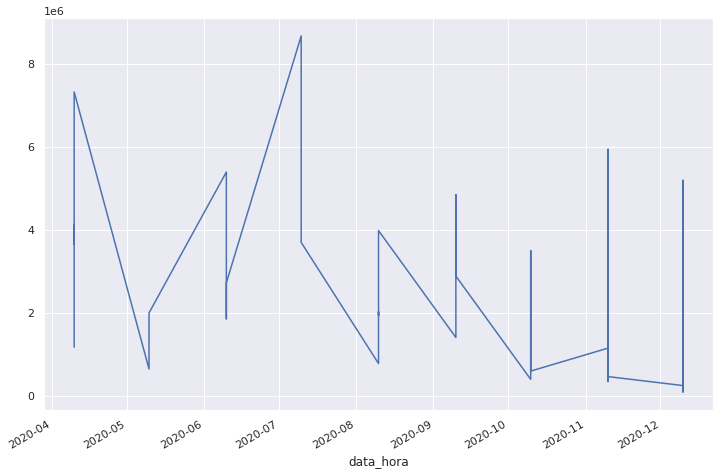

In [ ]:
%matplotlib inline

plt.figure(figsize=(12, 8))
data = invest_covidPe_forest.gastos
data.plot()

In [ ]:
from fbprophet import Prophet

prophet_df = data.reset_index()
prophet_df.columns = ["ds", "y"]
prophet_df.tail()

,ds,y
40,2020-12-10,1016127.00
41,2020-12-10,3084001.00
42,2020-12-10,180590.25
43,2020-12-10,696168.00
44,2020-12-10,211638.00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


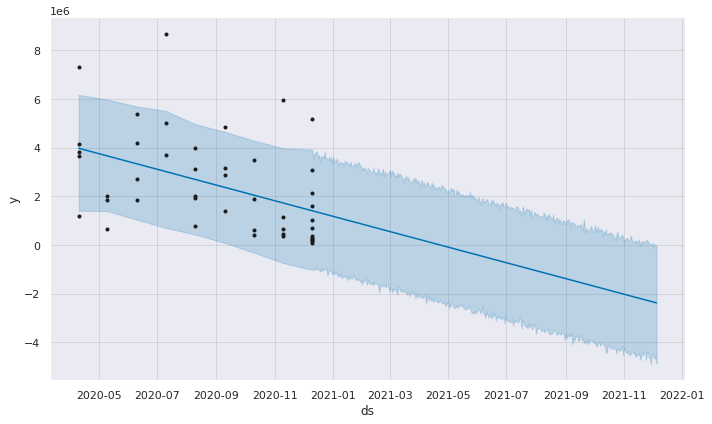

In [ ]:
m = Prophet()
m.fit(prophet_df)
pred = m.predict(m.make_future_dataframe(periods=360))
m.plot(pred); # weird bug causes to plot twice, put ; in the end

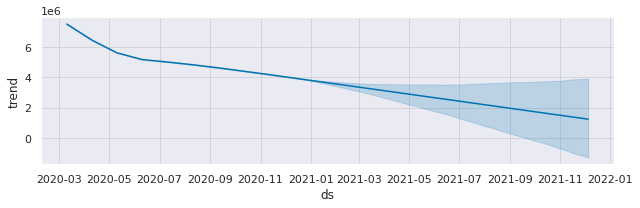

In [ ]:
m.plot_components(pred);

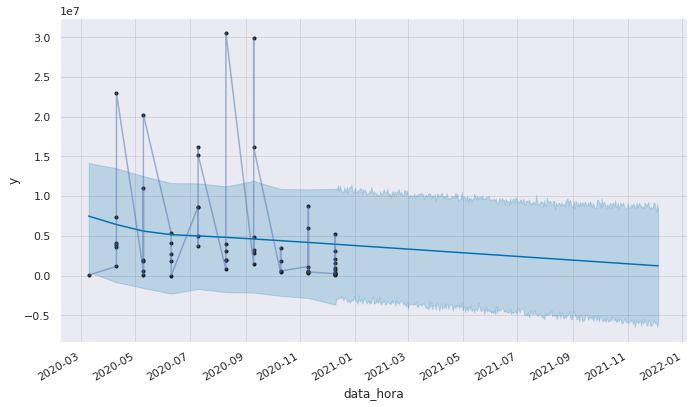

In [ ]:
m.plot(pred); # weird bug causes to plot twice, put ; in the end
data.plot(label='Gastos (em milhões)', alpha=.5)